## Cluster visualization
Display random representatives of the cluster

In [1]:
import pickle
import os
import sys
import numpy as np
from glob import glob
from sklearn.metrics.cluster import normalized_mutual_info_score
import seaborn as sn
import matplotlib.pyplot as plt
import json
import cv2




In [2]:
def arrange_clustering(images_lists):
    pseudolabels = []
    image_indexes = []
    for cluster, images in enumerate(images_lists):
        image_indexes.extend(images)
        pseudolabels.extend([cluster] * len(images))
    indexes = np.argsort(image_indexes)
    return np.asarray(pseudolabels)[indexes]

#### Links to files

In [3]:
clusters = "/home/aogorodnikov/model_alex_pos/clusters"
imgs = "/home/aogorodnikov/data/train"

In [4]:
with open(clusters, "rb") as f:
    b = pickle.load(f, encoding='latin1')

In [9]:
# clusters which each img belongs to at every epoch
img_clust = [arrange_clustering(x) for x in b]

15

In [6]:
im_names = [os.path.basename(x) for x in sorted(glob(os.path.join(imgs, '*.tif*')))]

In [14]:
epoch = 14

In [15]:
# Class of image clusters to export as JSON
# clusters - list of clustes
# images - array of images that were identified for this cluster

class Cluster(object):
  def __init__(self, clusters, images):
    self.clusters = []
    self.images = []
    
  def clust_append(self, cur_clust, im_id):
    self.clusters.append(cur_clust)
    self.images.append(im_id)
    

In [24]:
# create an object with attributes "clusters" and "images"
myObj = Cluster("Cluster", "Image")

# loop over clusters (j)
for j in range(0,len(b[epoch])):
    rel_img = [im_names[x] for x in np.where(img_clust[epoch] == j)[0]]
    myObj.clust_append(j, rel_img)


20670

In [31]:
lol = [len(x) for x in myObj.images]
for numb, i in enumerate(lol):
    print(numb,i)


0 16
1 9
2 4
3 20
4 5
5 8
6 230
7 102
8 39
9 23
10 28
11 2
12 56
13 26
14 51
15 12
16 20
17 129
18 50
19 14
20 47
21 38
22 9
23 14
24 16
25 3
26 77
27 18
28 62
29 2
30 35
31 81
32 17
33 5
34 2
35 185
36 18
37 6
38 34
39 4
40 56
41 18
42 4
43 11
44 11
45 13
46 101
47 2
48 8
49 272
50 50
51 2
52 12
53 33
54 47
55 42
56 15
57 71
58 79
59 126
60 135
61 19
62 24
63 40
64 99
65 46
66 27
67 17
68 36
69 173
70 5
71 77
72 7
73 2
74 70
75 70
76 54
77 40
78 12
79 3
80 8
81 8
82 32
83 4
84 29
85 44
86 222
87 24
88 20
89 30
90 43
91 44
92 24
93 2
94 5
95 10
96 15
97 7
98 92
99 53
100 12
101 9
102 431
103 3
104 19
105 24
106 330
107 12
108 46
109 3
110 6
111 81
112 41
113 46
114 5
115 35
116 119
117 5
118 97
119 48
120 67
121 2
122 13
123 80
124 30
125 70
126 4
127 20
128 43
129 3
130 113
131 15
132 84
133 21
134 3
135 7
136 26
137 11
138 6
139 71
140 16
141 22
142 101
143 5
144 30
145 4
146 82
147 56
148 5
149 239
150 4
151 28
152 6
153 10
154 5
155 9
156 101
157 18
158 280
159 14
160 45
161 4
162 

#### Export clusters and images to json file

In [10]:
with open(os.path.join("/data2/02_sudoku/model_alex/out", "_".join(["imCluster_epoch", str(epoch)])), "w") as file:
    json.dump(myObj.__dict__, file)

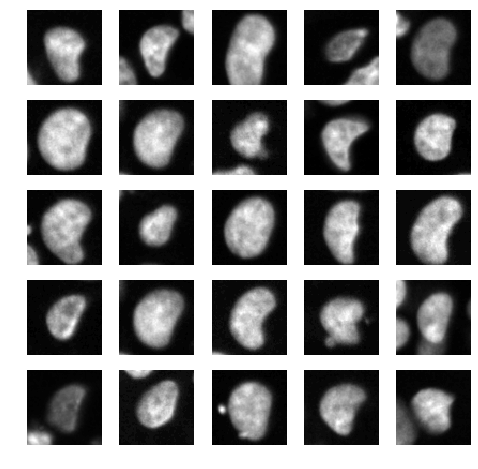

In [33]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
clust_to_plot = 20649

for k in range(1, columns * rows + 1):
    select_im = myObj.images[clust_to_plot]
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)]
    img_import = cv2.imread(os.path.join("/home/aogorodnikov/data/train", rand_select[0]), -1)
    fig.add_subplot(rows, columns, k)
    #plt.text(0, 0, s=rand_select)
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')
plt.show()


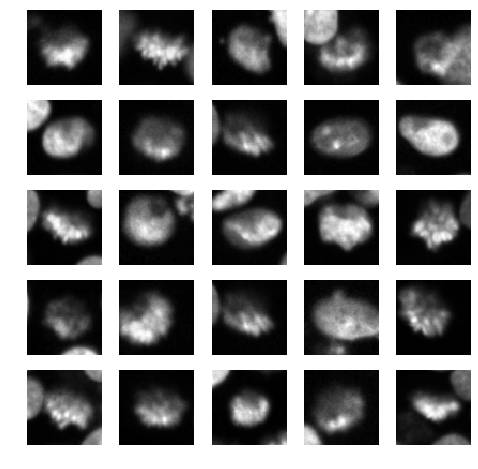

In [30]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
clust_to_plot = 6

for k in range(1, columns * rows + 1):
    select_im = myObj.images[clust_to_plot]
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)]
    img_import = cv2.imread(os.path.join("/home/aogorodnikov/data/train", rand_select[0]), -1)
    fig.add_subplot(rows, columns, k)
    #plt.text(0, 0, s=rand_select)
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')
plt.show()


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/aogorodnikov/a

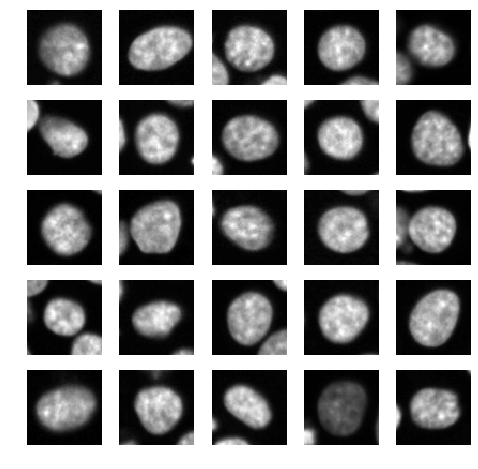

In [14]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
clust_to_plot = 36

for clust_to_plot in range(0, len(myObj.clusters)):
    
    for k in range(1, columns * rows + 1):
        select_im = myObj.images[clust_to_plot]
        rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)]
        img_import = cv2.imread(os.path.join("/data2/02_sudoku/cropped_1field", rand_select[0]), -1)
        fig.add_subplot(rows, columns, k)
        plt.imshow(img_import, cmap='gray');
        plt.axis('off')
    plt.savefig(fname=os.path.join("/data2/02_sudoku/model_alex/out", "_".join(['clust{0:02d}'.format(clust_to_plot),
                                                                            "out.pdf"])))

In [60]:
os.path.join("/data2/02_sudoku/cropped_1field", rand_select[0])

'/data2/02_sudoku/cropped_1field/Pt06_r03c06_0578.tif'

In [95]:
"_".join(['clust{0:02d}'.format(str(clust_to_plot)),"out.pdf"])


ValueError: Unknown format code 'd' for object of type 'str'